<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 47


Chromosome 7

* [R1 1000000-20000000](#r1)
* [R2 20000000-40000000](#r2) 
* [R3 40000000-50000000](#r3)
* [R4 70000000-90000000](#r4)
* [R5 90000000-110000000](#r5)
* [R6 110000000-130000000](#r6)
* [R7 130000000-150000000](#r7)



In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from pomegranate import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from helpers import read_configuration_file, INFO, WARNING
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [4]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [5]:
sns.set(color_codes=True)

Apply ```HMM_Model_9.json``` in regions:  

- ```region_0_REGION_1_CHR_7_MEAN_CUTOFF.txt```  [1000000-20000000]
- ```region_0_REGION_2_CHR_7_MEAN_CUTOFF.txt```  [20000000-40000000]
- ```region_0_REGION_3_CHR_7_MEAN_CUTOFF.txt```  [40000000-50000000]
- ```region_0_REGION_4_CHR_7_MEAN_CUTOFF.txt```  [70000000-90000000]
- ```region_0_REGION_5_CHR_7_MEAN_CUTOFF.txt``` [90000000-110000000]
- ```region_0_REGION_6_CHR_7_MEAN_CUTOFF.txt``` [110000000-130000000]
- ```region_0_REGION_7_CHR_7_MEAN_CUTOFF.txt``` [130000000-150000000]


Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


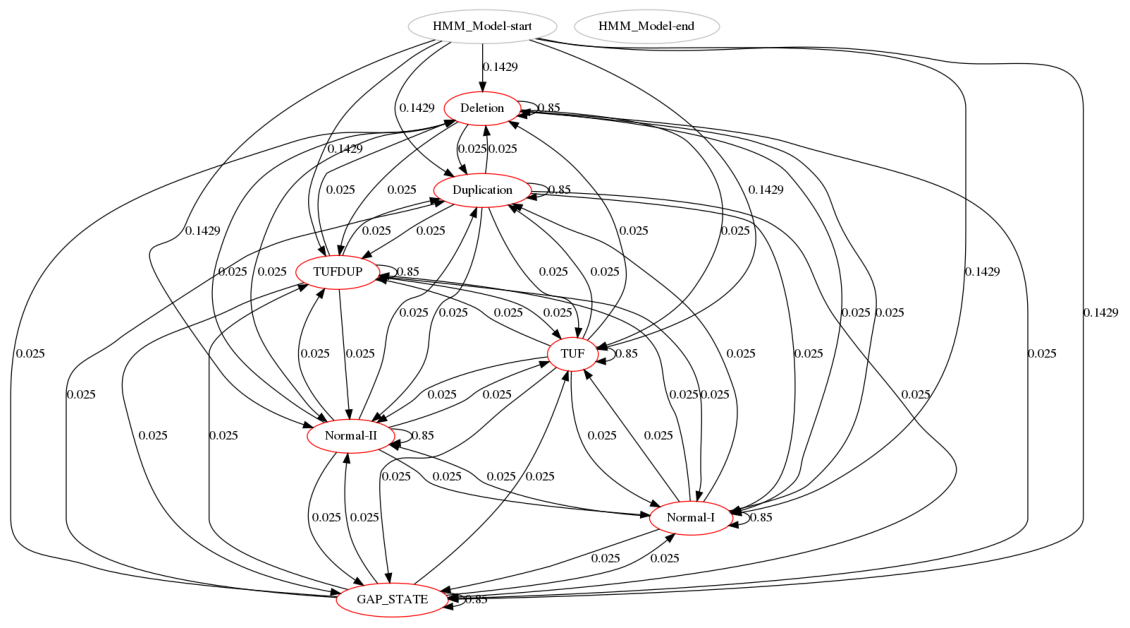

In [6]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]
hmm_filename = "HMM_Model_9.json"
hmm_model = build_hmm(hmm_file=hmm_filename)
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

## <a name="r1"></a>  Region 1

In [9]:
# load the region we want to use for prediction
region_name = "region_0_REGION_1_CHR_7_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_1_CHR_7_MEAN_CUTOFF.txt
Sequence length:  190000


In [11]:
filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model,
                                                                         chr='chr7',
                                                                         filename=filename)

Observation length:  190000
Done. Execution time 0.495267624999542 secs
Log-probability of ML Viterbi path:  -1264499.5135691615
Viterbi path length:  190001
There should be 0 gaps


In [12]:
# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr7', filename=filename)

Length of path  190000
Length of TUF+DELETION+TUF state:  1526


In [13]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  190000
Encountered gaps:  0


In [14]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

{'Duplication': 90, 'Normal-I': 150409, 'Normal-II': 34640, 'Deletion': 232, 'Single-Deletion': 0, 'TUF': 4628, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 1}


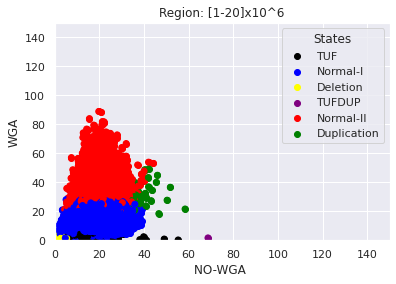

HMM labels color:  {'black': [5, 4628], 'blue': [1, 150409], 'yellow': [3, 232], 'purple': [6, 1], 'red': [2, 34640], 'green': [0, 90]}


In [15]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [1-20]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

In [16]:
for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

State:  Duplication
WGA mean/var:  27.607777777777777 37.897561728395054
NO-WGA mean/var:  35.75788888888888 27.425232209876544
State:  Normal-I
WGA mean/var:  15.697636444627651 25.48045824489269
NO-WGA mean/var:  18.670039957715296 23.63248018177007
State:  Normal-II
WGA mean/var:  30.262502598152427 47.07820330686392
NO-WGA mean/var:  19.83564058891455 20.492597332140072
State:  Deletion
WGA mean/var:  1.002758620689655 1.4080898038049938
NO-WGA mean/var:  2.082413793103448 1.8357605529131986
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.670259291270527 2.5038485498812606
NO-WGA mean/var:  13.53847882454624 19.829996130277618
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP
WGA mean/var:  1.65 0.0
NO-WGA mean/var:  68.67 0.0


In [14]:
#plot_hmm_label_state(hmm_states_to_labels=hmm_states_to_labels, hmm_labels=hmm_labels, 
#                     no_wga_obs=no_wga_obs, wga_obs=wga_obs, nbins=80, xlim=(0.0, 140.),ylim=(0.0, 140.))

State:  Deletion
[[0.970271600267186, 0.958137372653406], [[1.1036072543648185, 0.0], [0.0, 1.1932036611641303]]]
State:  Duplication
[[24.283621138294365, 55.0], [[39.473393085057296, 0.0], [0.0, 71.53462337717849]]]
State:  Normal-I
[[13.750290519035646, 16.65535114027298], [[19.019257854346822, 0.0], [0.0, 31.488140792022595]]]
State:  Normal-II
[[40.0, 19.641842481040367], [[52.49115328954019, 0.0], [0.0, 19.606180750829882]]]
State:  TUF
[[1.7345118994138116, 14.220278071386755], [[1.9260086547849433, 0.0], [0.0, 15.655595281606255]]]
[[1.7345118994138116, 40.0], [[1.9260086547849433, 0.0], [0.0, 28.60670595671783]]]
Weights found:  [-0.69314718 -0.69314718]
Weights:  [0.5 0.5]
State:  TUFDUP
[[1.7345118994138116, 85.0], [[1.9260086547849433, 0.0], [0.0, 93.36225933227568]]]
state:  TUF
state:  Deletion
state:  Duplication
state:  Normal-I
state:  Normal-II
state:  TUFDUP


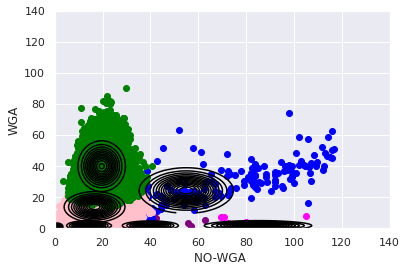

In [15]:
obs_state = {}

for state in hmm_states_to_labels:
    obs_state[state] = []

for i, obs in enumerate(observations):
        if obs != (-999.0, -999.0):
            viterbi_state = sequence_viterbi_state[i][1]
            obs_state[viterbi_state].append(obs)
            
states = hmm_model.states

state_vars = {}

for state in states:
    
    if state.name in hmm_states_to_labels:
        
        print("State: ", state.name)
        
        if state.distribution.name == "MultivariateGaussianDistribution":
            print(state.distribution.parameters)
            
            state_vars[state.name] = state.distribution.parameters
            
        elif state.name == 'TUF':
            
            state_vars[state.name] = {}
           
            for i, comp in enumerate(state.distribution.distributions):
                state_vars[state.name]["comp"+str(i)] = comp.parameters
                print(comp.parameters)
            weights = state.distribution.weights
            print("Weights found: ", weights)
            state_vars[state.name]["weights"] = np.exp(weights) 
            print("Weights: ", state_vars[state.name]["weights"])


state_colors={'TUF':"purple", "Deletion":"red",
                'Duplication':"blue", "Normal-I":"pink",
                "Normal-II":"green",
             'TUFDUP':'magenta'}

state_min_max = {'TUF':{'min_x': 0.0, 'max_x':140.0, 'min_y': 0.0, 'max_y':10.0},
                 'TUFDUP':{'min_x': 40.0, 'max_x':140.0, 'min_y': 0.0, 'max_y':10.0},
                 'Deletion':{'min_x': 0.0, 'max_x':10.0, 'min_y': 0.0, 'max_y':10.0},
                 'Normal-II':{'min_x': 0.0, 'max_x':45.0, 'min_y': 0.0, 'max_y':140.0},
                 'Normal-I':{'min_x': 0.0, 'max_x':45.0, 'min_y': 0.0, 'max_y':35.0},
                 'Duplication':{'min_x': 20.0, 'max_x':140.0, 'min_y': 10.0, 'max_y':140.0}}

plot_hmm_cluster_contours(state_colors=state_colors, state_vars=state_vars, 
                          obs_state=obs_state, nbins=80, ncontours=14, state_min_max=state_min_max)

## <a name="r2"></a> Region 2

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_2_CHR_7_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.6196061939990614 secs
Log-probability of ML Viterbi path:  -1354022.207480704
Viterbi path length:  200001
There should be 0 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  57
Length of WGA Observations:  200000
Encountered gaps:  0
{'Duplication': 64, 'Normal-I': 143327, 'Normal-II': 56062, 'Deletion': 84, 'Single-Deletion': 0, 'TUF': 463, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


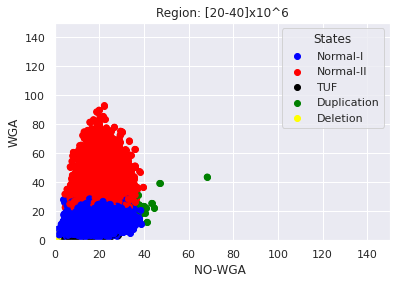

HMM labels color:  {'blue': [1, 143327], 'red': [2, 56062], 'black': [5, 463], 'green': [0, 64], 'yellow': [3, 84]}
State:  Duplication
WGA mean/var:  24.00375 23.696751562499998
NO-WGA mean/var:  35.5571875 30.439179589843754
State:  Normal-I
WGA mean/var:  16.622771843407033 24.039619461804485
NO-WGA mean/var:  18.458495538174944 21.207075382118486
State:  Normal-II
WGA mean/var:  31.118024865327673 57.20526792824619
NO-WGA mean/var:  19.576039028218755 18.66596773619575
State:  Deletion
WGA mean/var:  0.7960714285714287 1.547550042517007
NO-WGA mean/var:  0.9561904761904765 1.8600902494331066
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.4610799136069117 1.6153314471775304
NO-WGA mean/var:  12.473606911447083 23.573633858440356
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [17]:
# load the region we want to use for prediction
region_name = "region_0_REGION_2_CHR_7_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr7',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr7', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [20-40]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r3"></a>  Region 3

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_3_CHR_7_MEAN_CUTOFF.txt
Sequence length:  100000
Observation length:  100000
Done. Execution time 0.25675393200071994 secs
Log-probability of ML Viterbi path:  -676167.6007181731
Viterbi path length:  100001
There should be 0 gaps
Length of path  100000
Length of TUF+DELETION+TUF state:  232
Length of WGA Observations:  100000
Encountered gaps:  0
{'Duplication': 43, 'Normal-I': 74754, 'Normal-II': 24651, 'Deletion': 39, 'Single-Deletion': 0, 'TUF': 513, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


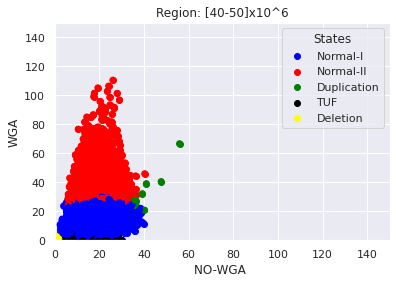

HMM labels color:  {'blue': [1, 74754], 'red': [2, 24651], 'green': [0, 43], 'black': [5, 513], 'yellow': [3, 39]}
State:  Duplication
WGA mean/var:  26.97813953488372 55.60298258518116
NO-WGA mean/var:  34.31348837209302 25.54280411032991
State:  Normal-I
WGA mean/var:  16.558611713085583 24.423255006067688
NO-WGA mean/var:  18.30605960885036 21.32320055540015
State:  Normal-II
WGA mean/var:  30.74091882682244 59.632990519190805
NO-WGA mean/var:  19.529232891160603 18.84629436509561
State:  Deletion
WGA mean/var:  0.9033333333333334 1.6266991452991455
NO-WGA mean/var:  1.9417948717948719 1.6483737015121631
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.8569590643274854 2.2831927020279745
NO-WGA mean/var:  13.755438596491228 23.467070421668208
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [18]:
# load the region we want to use for prediction
region_name = "region_0_REGION_3_CHR_7_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr7',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr7', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [40-50]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r4"></a>  Region 4

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_4_CHR_7_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.5031373809997604 secs
Log-probability of ML Viterbi path:  -1337413.9277208105
Viterbi path length:  200001
There should be 0 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  867
Length of WGA Observations:  200000
Encountered gaps:  0
{'Duplication': 90, 'Normal-I': 160647, 'Normal-II': 37353, 'Deletion': 347, 'Single-Deletion': 0, 'TUF': 1563, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


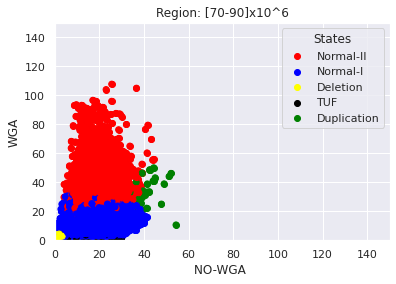

HMM labels color:  {'red': [2, 37353], 'blue': [1, 160647], 'yellow': [3, 347], 'black': [5, 1563], 'green': [0, 90]}
State:  Duplication
WGA mean/var:  28.089555555555556 58.596046469135814
NO-WGA mean/var:  36.13366666666666 29.486700999999993
State:  Normal-I
WGA mean/var:  15.878103543794776 24.539591802060748
NO-WGA mean/var:  18.76786718706232 24.248616177919928
State:  Normal-II
WGA mean/var:  30.932050437715844 62.41459802042607
NO-WGA mean/var:  19.5055157550933 21.588980421625525
State:  Deletion
WGA mean/var:  1.1061383285302593 1.6918997848997999
NO-WGA mean/var:  1.421815561959654 1.9670477123803038
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.596346769033909 2.3935501215938477
NO-WGA mean/var:  13.44874600127959 24.720535087755927
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [19]:
# load the region we want to use for prediction
region_name = "region_0_REGION_4_CHR_7_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr7',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr7', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [70-90]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r5"></a>  Region 5

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_5_CHR_7_MEAN_CUTOFF.txt
Sequence length:  199937
Observation length:  199937
Done. Execution time 0.5105864149991248 secs
Log-probability of ML Viterbi path:  -1359755.837896094
Viterbi path length:  199938
There should be 0 gaps
Length of path  199937
Length of TUF+DELETION+TUF state:  290
Length of WGA Observations:  199937
Encountered gaps:  0
{'Duplication': 263, 'Normal-I': 144653, 'Normal-II': 53374, 'Deletion': 274, 'Single-Deletion': 0, 'TUF': 1369, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 4}


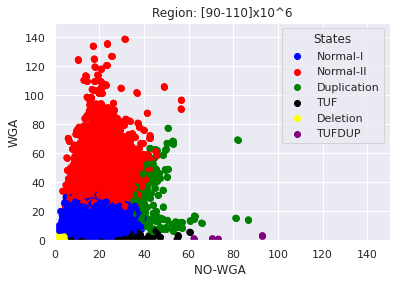

HMM labels color:  {'blue': [1, 144653], 'red': [2, 53374], 'green': [0, 263], 'black': [5, 1369], 'yellow': [3, 274], 'purple': [6, 4]}
State:  Duplication
WGA mean/var:  26.905323193916352 178.70105303242778
NO-WGA mean/var:  39.273574144486695 75.21138798594748
State:  Normal-I
WGA mean/var:  16.311063095822416 25.288084099998787
NO-WGA mean/var:  18.353693044734644 22.4988318475149
State:  Normal-II
WGA mean/var:  31.501718627046877 72.68734810301534
NO-WGA mean/var:  19.51466669164762 21.383621640132734
State:  Deletion
WGA mean/var:  0.6627372262773723 1.00219287255581
NO-WGA mean/var:  0.8175182481751826 1.6680566146305078
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.586077428780132 2.3125566368097514
NO-WGA mean/var:  15.71045288531775 44.853309656107456
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP
WGA mean/var:  1.6025 0.9149187500000002
NO-WGA mean/var:  74.83250000000001 126.81781874999999


In [20]:
# load the region we want to use for prediction
region_name = "region_0_REGION_5_CHR_7_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr7',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr7', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [90-110]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r6"></a>  Region 6 

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_6_CHR_7_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.8082242509990465 secs
Log-probability of ML Viterbi path:  -1347573.6618245363
Viterbi path length:  200001
There should be 0 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  52
Length of WGA Observations:  200000
Encountered gaps:  0
{'Duplication': 136, 'Normal-I': 156762, 'Normal-II': 42532, 'Deletion': 125, 'Single-Deletion': 0, 'TUF': 445, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


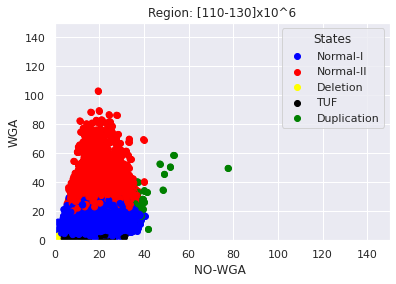

HMM labels color:  {'blue': [1, 156762], 'red': [2, 42532], 'yellow': [3, 125], 'black': [5, 445], 'green': [0, 136]}
State:  Duplication
WGA mean/var:  26.062720588235294 43.33690803957612
NO-WGA mean/var:  34.92360294117647 33.28642745999135
State:  Normal-I
WGA mean/var:  16.3609226087955 23.302573467186495
NO-WGA mean/var:  19.526573212895983 21.386618342865205
State:  Normal-II
WGA mean/var:  30.203770807862316 47.723559974556444
NO-WGA mean/var:  20.376135615536537 18.397342844206
State:  Deletion
WGA mean/var:  0.8090399999999999 1.3698070783999998
NO-WGA mean/var:  1.1381599999999998 2.0443382144
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.2857528089887635 1.548668927660649
NO-WGA mean/var:  15.215550561797754 24.33321346092665
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [21]:
# load the region we want to use for prediction
region_name = "region_0_REGION_6_CHR_7_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr7',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr7', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [110-130]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r7"></a>  Region 7

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_7_CHR_7_MEAN_CUTOFF.txt
Sequence length:  199998
Observation length:  199998
Done. Execution time 0.8495291719991656 secs
Log-probability of ML Viterbi path:  -1355505.5773621597
Viterbi path length:  199999
There should be 501 gaps
Length of path  199998
Length of TUF+DELETION+TUF state:  389
Length of WGA Observations:  199497
Encountered gaps:  501
{'Duplication': 168, 'Normal-I': 139737, 'Normal-II': 57470, 'Deletion': 213, 'Single-Deletion': 0, 'TUF': 1909, 'GAP_STATE': 501, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


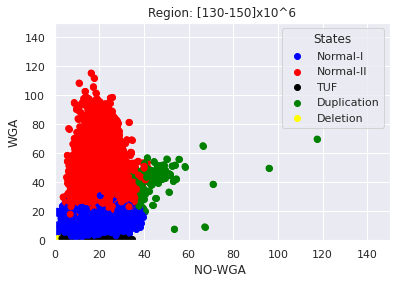

HMM labels color:  {'blue': [1, 139737], 'red': [2, 57470], 'black': [5, 1909], 'green': [0, 168], 'yellow': [3, 213]}
State:  Duplication
WGA mean/var:  34.71261904761905 124.22090504535147
NO-WGA mean/var:  40.244107142857146 110.95398134566325
State:  Normal-I
WGA mean/var:  16.3891712288084 25.361832437507662
NO-WGA mean/var:  18.227529144034868 22.41027695447563
State:  Normal-II
WGA mean/var:  31.975925352357756 73.19318797528729
NO-WGA mean/var:  19.23192448233861 19.613536070162752
State:  Deletion
WGA mean/var:  1.0828169014084505 1.5555319711697415
NO-WGA mean/var:  1.6360563380281692 1.9890210672485618
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.548313253012048 2.5732427284833412
NO-WGA mean/var:  14.776778418019907 25.119691088146055
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [22]:
# load the region we want to use for prediction
region_name = "region_0_REGION_7_CHR_7_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr7',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr7/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr7', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [130-150]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))